In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar
import warnings

plt.rcParams['figure.figsize'] = (8, 8)
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("banktransaction.csv")

In [3]:
df.head()

,typeofaction,sourceid,destinationid,amountofmoney,date,isfraud,typeoffraud
0,cash-in,30105,28942,494528,2019-07-19 14:40:00,1,type1
1,cash-in,30105,8692,494528,2019-05-17 14:57:00,1,type1
2,cash-in,30105,60094,494528,2019-07-20 13:20:00,1,type1
3,cash-in,30105,20575,494528,2019-07-03 14:15:00,1,type1
4,cash-in,30105,45938,494528,2019-05-26 10:40:00,1,type1


We can observe that the date is in 'datetime' format so we can feature engineer and create valuable features

In [4]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour

df['month_name'] = df['month'].apply(lambda x: calendar.month_abbr[x])

## Check Null

In [5]:
df.isnull().sum()

typeofaction     0
sourceid         0
destinationid    0
amountofmoney    0
date             0
isfraud          0
typeoffraud      0
year             0
month            0
day              0
hour             0
month_name       0
dtype: int64

# Data Analysis

## 1. Check for Class Imbalance

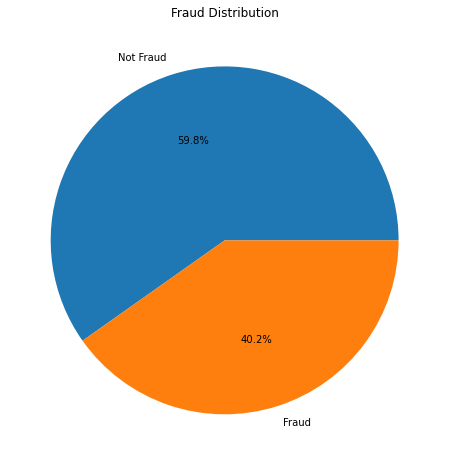

In [7]:
fraud_count = df['isfraud'].value_counts()
plt.pie(fraud_count, labels=['Not Fraud', 'Fraud'], autopct='%1.1f%%')
plt.title('Fraud Distribution')
plt.show()

The dataset has class imbalance. We need to fix this if we want to use LogisticRegression or similar model that is affected by imbalance

Note: Accuracy is not always the best metric
Not all errors are created equal. Our task is high-stakes, and understanding the nature of misclassifications is paramount. Consider these two scenarios:

Scenario 1: False Alarm - Non-Fraud Detected as Fraud Imagine a legitimate transaction being flagged as fraudulent by our model. Fortunately, this is a minor setback, akin to a false alarm. The issue can be quickly resolved through verification, causing minimal impact on both the bank and the customer.

Scenario 2: Missed Fraud - The Costly Oversight Now, let's flip the coin. A genuine fraudulent transaction slips through our model's defenses, undetected. This is where the stakes skyrocket. It's akin to a security breach in a high-security vault - the consequences are significant and potentially catastrophic.

In our world of fraud detection, accuracy is essential, but it's not the sole measure of success. We prioritize precision, especially when the cost of misclassification can have severe repercussions.

## 2. Types of Money Transfers

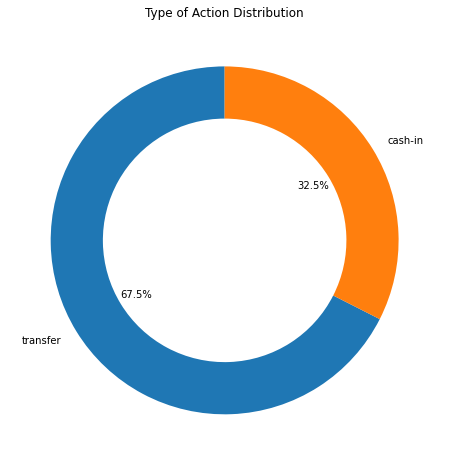

In [8]:
action_count = df['typeofaction'].value_counts()
plt.pie(action_count, labels=action_count.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))
plt.title('Type of Action Distribution')
plt.show()

Customers prefer online transfer. Lets check what percentages of frauds occur in thees two

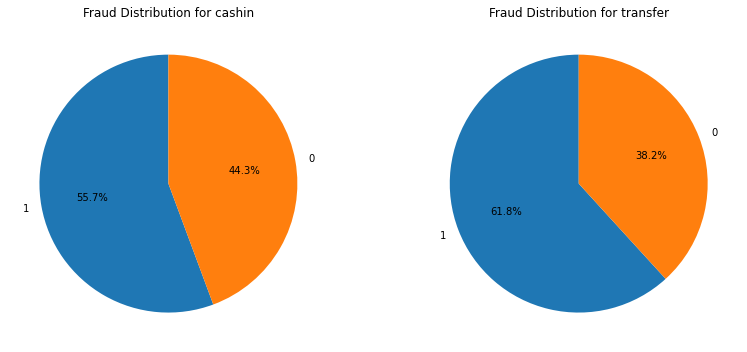

In [9]:
import matplotlib.pyplot as plt

cashin_data = df[df['typeofaction'] == 'cash-in']
transfer_data = df[df['typeofaction'] == 'transfer']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart for 'cashin'
if len(cashin_data) > 0:
    cashin_counts = cashin_data['isfraud'].value_counts()
    axes[0].pie(cashin_counts, labels=cashin_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Fraud Distribution for cashin')
else:
    axes[0].text(0.5, 0.5, 'No cashin data', ha='center', va='center', fontsize=12)

# Pie chart for 'transfer'
if len(transfer_data) > 0:
    transfer_counts = transfer_data['isfraud'].value_counts(dropna=False)
    axes[1].pie(transfer_counts, labels=transfer_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Fraud Distribution for transfer')
else:
    axes[1].text(0.5, 0.5, 'No transfer data', ha='center', va='center', fontsize=12)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

Surprisingly, there are more frauds occuring in cash-in transfer than in online-transfer

## 3. Visualizing kinds of money transfer

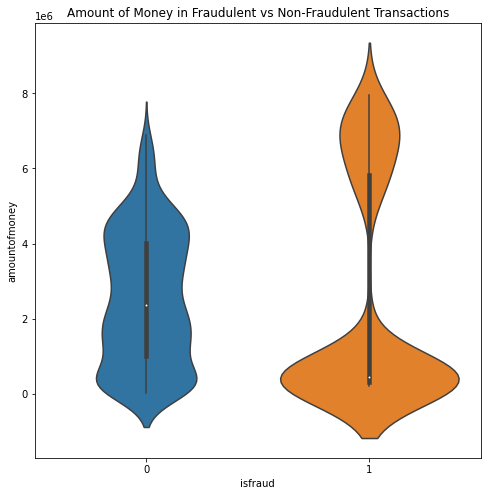

In [10]:
sns.violinplot(x='isfraud', y='amountofmoney', data=df)
plt.title('Amount of Money in Fraudulent vs Non-Fraudulent Transactions')
plt.show()

We can not the dataset has a cut-off after a certain value, where all transactions are marked as fraudulent. These however maynot be the case in real-world but just a precautionary measure given that the value of money being transacted is very large.



## 4. Trends in Fraud

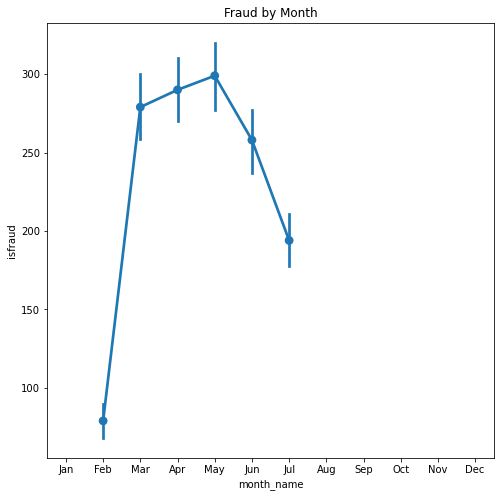

In [11]:
sns.pointplot(x='month_name', y='isfraud', data=df, estimator=np.sum, order=list(calendar.month_abbr[1:]))
plt.title('Fraud by Month')
plt.show()

Given data is not large enough to explain fraud trends as the dataset consists of only 1 year of transactions.

Note: Misleading numbers and patterns

The above plot clearly shows a trend that March-July as a high-time for frauds. But since the data is of only 1 year, we cannot conclude nor reject the theory/pattern.

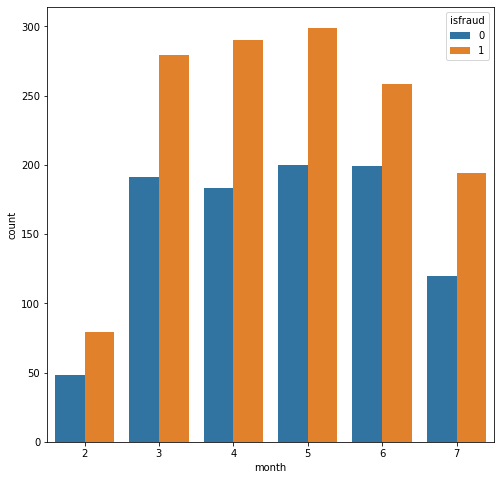

In [12]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour

sns.countplot(x='month', hue='isfraud', data=df)
plt.show()

## 5. Distribution of Fraud Types

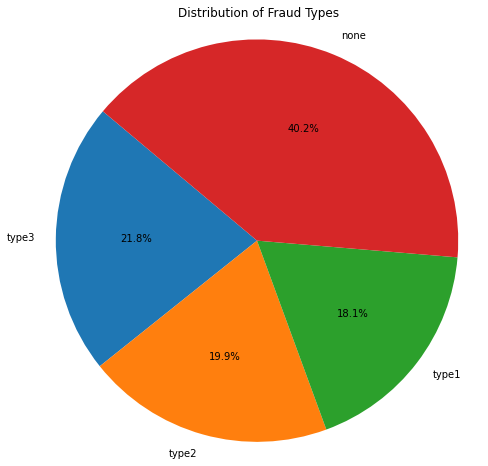

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fraud_counts = df[df['isfraud'] == 1]['typeoffraud'].value_counts()

plt.figure(figsize=(8, 8))
fraud_counts['none'] = df['typeoffraud'].value_counts().get('none', 0) 
plt.pie(fraud_counts, labels=fraud_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Fraud Types')
plt.axis('equal') 
plt.show()

- 40% of the given data is non-fraud.

- When creating multi-class model for the above, we dont need 'none' data for training this model

## 6. Check for Outliers

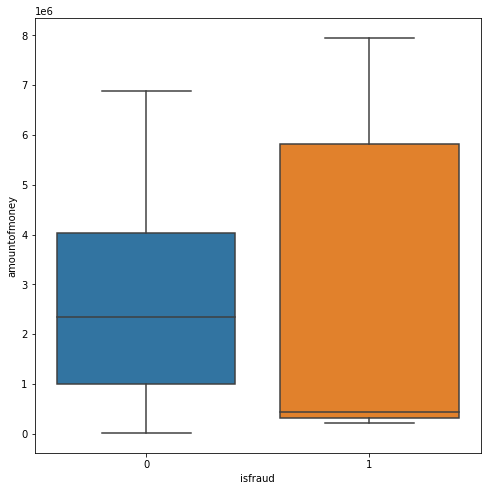

In [14]:
sns.boxplot(x='isfraud', y='amountofmoney', data=df)
plt.show()

- Most frauds occuring have a range that is similar to non-fraud transactions
- If we consider using outlier removals, we will lose valuable information on transaction of customers to improve their experience. Logically, it doesnt make sense.

## 7. Histogram to understand data


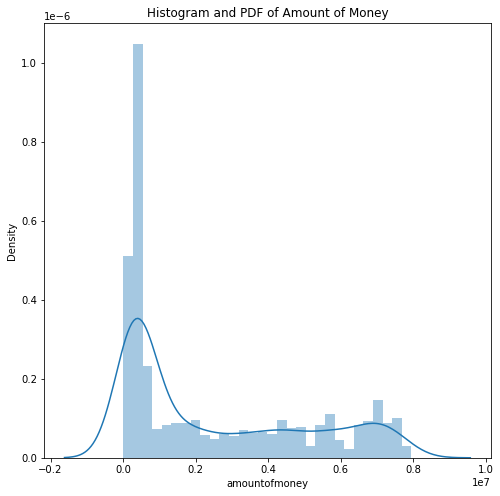

In [15]:
sns.distplot(df['amountofmoney'], kde=True, bins=30)
plt.title('Histogram and PDF of Amount of Money')
plt.show()

The above follows something of a Pareto law. That is, 20% of transactions account for 80% of total wealth transactions. We can apply Log transformation on this to create a distribution closer to normal distribution.

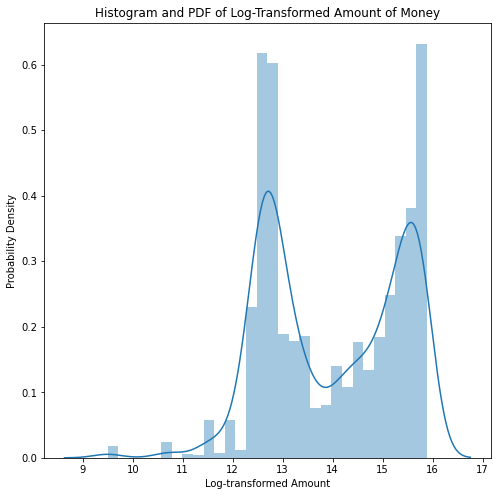

In [16]:
df['log_amount'] = np.log1p(df['amountofmoney'])

sns.distplot(df['log_amount'], kde=True, bins=30)
plt.title('Histogram and PDF of Log-Transformed Amount of Money')
plt.xlabel('Log-transformed Amount')
plt.ylabel('Probability Density')
plt.show()

The log-transformed feature does not represent normal distribution. We cannot derive statistical observations from this, as we could if it were a normal.

## 8. Check for Correlation

Most classical algorithms are highly affected by correlation. Let's check if the given data consists of any



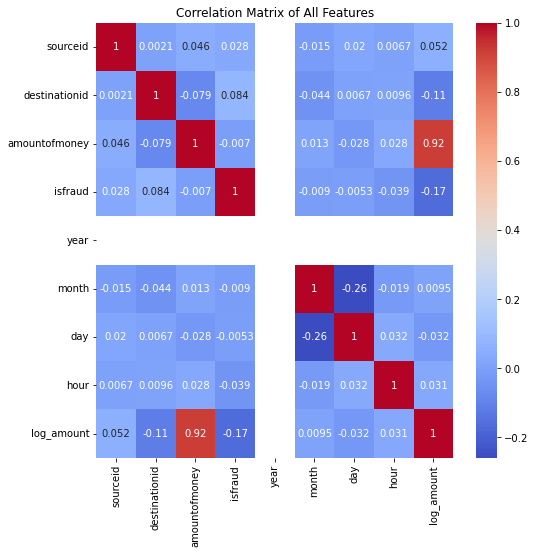

In [17]:
correlation_matrix = df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of All Features')
plt.show()

Clearly there are no highly-correlated variables

# Train Test Split

I am using dummy encoding (same as onehotenc but looks neat in code). Theoritically it will create correlation in the nth dimension. As a result weights of the model will be disturbed and wont logically represent feature importance. So if you want to observe feature importance, continue by dropping any one among the n encoded columns.

Since data size is very low, we need to compromise on split. I'm going with 80-20, dont go over 70-30 because you will end up with lower amount of train data.

I do not recommend creating synthetic data. Just as life, nothing comes free in data too. Creating synthetic data carries a risk of:

- Overfit
- Quality loss
- Assumptions
- Bias
- and so on

In [20]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("banktransaction.csv")
df = pd.get_dummies(df, columns=['typeofaction'])

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour

y = df['isfraud']
y_type = df['typeoffraud']

df = df.drop(columns=['date','typeoffraud','isfraud'])
X = df.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X_train.head()

,sourceid,destinationid,amountofmoney,typeofaction_cash-in,typeofaction_transfer,year,month,day,hour
787,33473,32740,7422956,0,1,2019,4,17,10
1503,45772,24950,131219,1,0,2019,6,14,15
1187,78804,86903,215499,0,1,2019,5,11,12
679,25531,37485,7012527,0,1,2019,5,19,11
65,1615,72623,639229,1,0,2019,7,18,10


# Models - Binary

As mentioned earlier, greater recall is more valuable than accuracy or precision.

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# increased class weights
class_weights = {0: 0.3, 1: 0.7}  

# RandomForestClassifier with class weights
rf = RandomForestClassifier(class_weight=class_weights, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='recall')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

y_pred = best_estimator.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.9423076923076923
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       180
           1       0.92      0.99      0.95       288

    accuracy                           0.94       468
   macro avg       0.95      0.93      0.94       468
weighted avg       0.95      0.94      0.94       468



This is just a baseline model. You can try different models and check for best results (recall)



# Scatter plot on top 3 features

Since the model performs very well, we might be able to understand why through scatter plot. If we reduce dimensions in the direction of maximum variance, the data might be linearly seperable. Lets try



In [23]:
import numpy as np

feature_importances = best_estimator.feature_importances_
top_three_indices = np.argsort(feature_importances)[-6:][::-1]  # sort and get top 3
feature_names = list(X_test.columns) 

print("Top 3 important features are:")
for i, index in enumerate(top_three_indices):
    print(f"{i+1}. {feature_names[index]} (Importance: {feature_importances[index]:.4f})")

X_test_important = X_test.iloc[:, top_three_indices]

Top 3 important features are:
1. amountofmoney (Importance: 0.6998)
2. sourceid (Importance: 0.0842)
3. destinationid (Importance: 0.0703)
4. typeofaction_transfer (Importance: 0.0439)
5. typeofaction_cash-in (Importance: 0.0378)
6. day (Importance: 0.0304)


Only 1 feature is important. Let's try 1D scatter plot but it wont be of much use



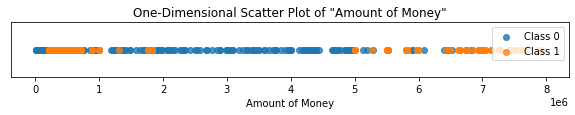

In [24]:
X_test_important_array = np.array(X_test_important['amountofmoney'])  
y_test_array = np.array(y_test)
mask_class_0 = (y_test_array == 0)
mask_class_1 = (y_test_array == 1)

plt.figure(figsize=(10, 1))
plt.scatter(X_test_important_array[mask_class_0], [0]*np.sum(mask_class_0), alpha=0.8, label='Class 0')
plt.scatter(X_test_important_array[mask_class_1], [0]*np.sum(mask_class_1), alpha=0.8, label='Class 1')
plt.title('One-Dimensional Scatter Plot of "Amount of Money"')
plt.xlabel('Amount of Money')
plt.yticks([])  
plt.legend()

plt.show()

Maybe histograms would give better understanding



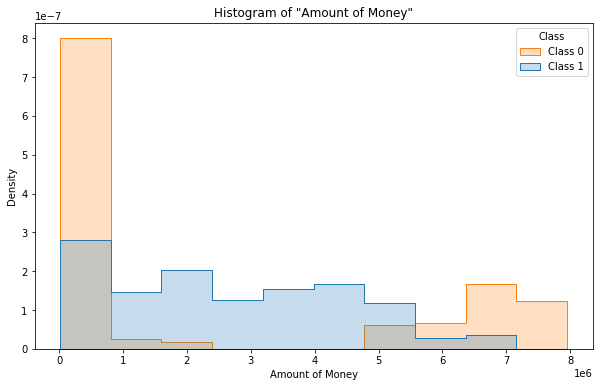

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(X_test_important, x='amountofmoney', hue=y_test, element='step', stat='density', common_norm=False)
plt.title('Histogram of "Amount of Money"')
plt.xlabel('Amount of Money')
plt.ylabel('Density')
plt.legend(title='Class', labels=['Class 0', 'Class 1'])

plt.show()

TNSE visualization of the dataset



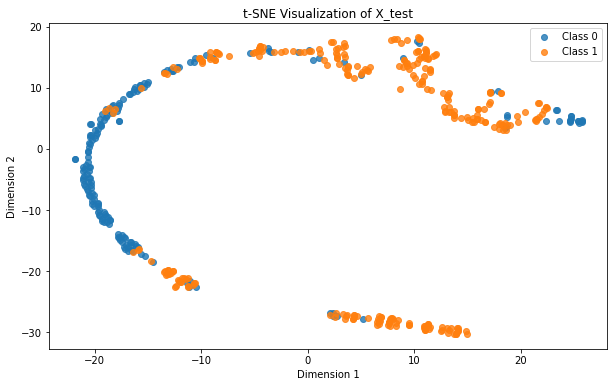

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_test_tsne = tsne.fit_transform(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(X_test_tsne[y_test == 0, 0], X_test_tsne[y_test == 0, 1], alpha=0.8, label='Class 0')
plt.scatter(X_test_tsne[y_test == 1, 0], X_test_tsne[y_test == 1, 1], alpha=0.8, label='Class 1')
plt.title('t-SNE Visualization of X_test')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

plt.show()

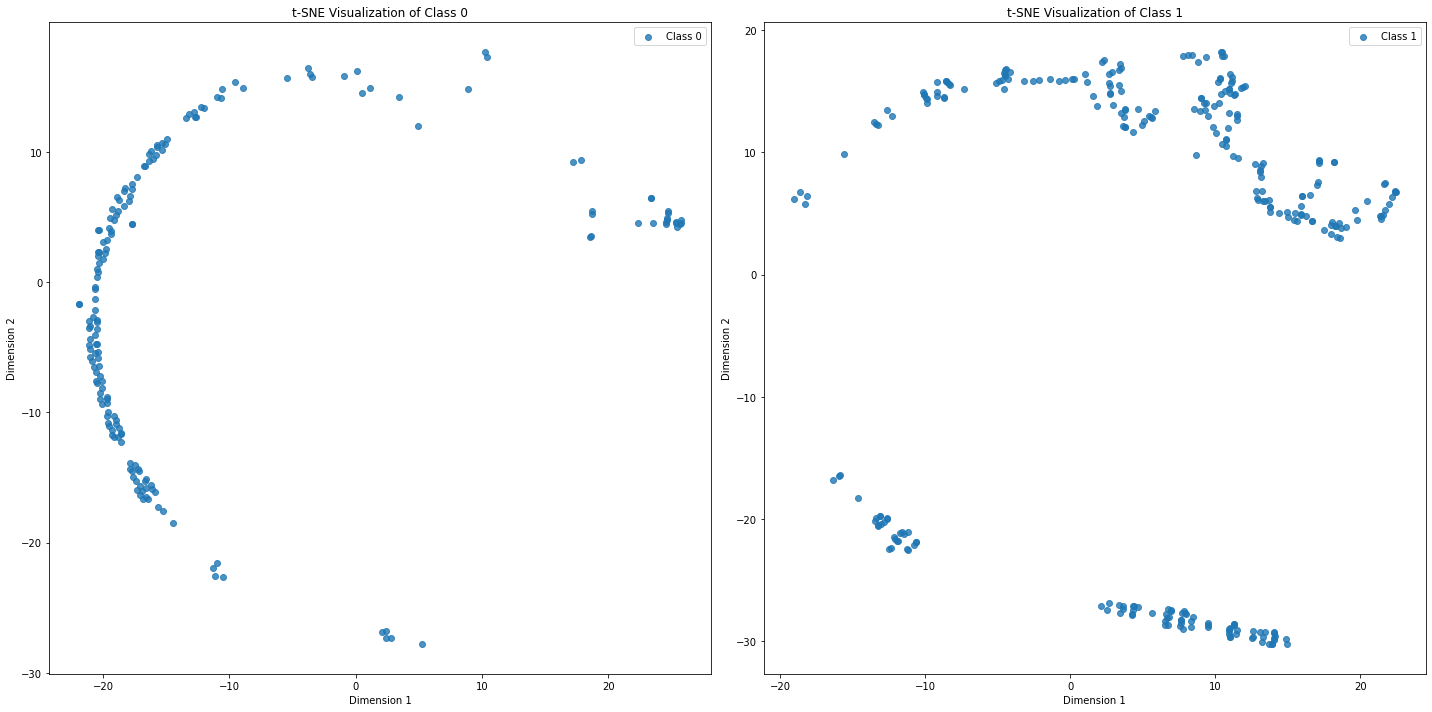

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(n_components=2, random_state=42)
X_test_tsne = tsne.fit_transform(X_test)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].scatter(X_test_tsne[y_test == 0, 0], X_test_tsne[y_test == 0, 1], alpha=0.8, label='Class 0')
axes[0].set_title('t-SNE Visualization of Class 0')
axes[0].set_xlabel('Dimension 1')
axes[0].set_ylabel('Dimension 2')
axes[0].legend()

axes[1].scatter(X_test_tsne[y_test == 1, 0], X_test_tsne[y_test == 1, 1], alpha=0.8, label='Class 1')
axes[1].set_title('t-SNE Visualization of Class 1')
axes[1].set_xlabel('Dimension 1')
axes[1].set_ylabel('Dimension 2')
axes[1].legend()

plt.tight_layout()
plt.show()

We can observe that frauds occur only at certain areas in the t-SNE plot, it suggests that the fraudulent activities form distinct clusters or seperable hyperplanes within the high-dimensional feature space. This clustering implies that there are underlying patterns or similarities among the fraudulent cases that set them apart from non-fraudulent ones.

# Hypertuning model predictions

Right now the model is focusing on recall, it is because I set the scoring on my training to recall instead of accuracy. But still, for theoritical understanding, below is how we can select the best model predictions and cut-offs

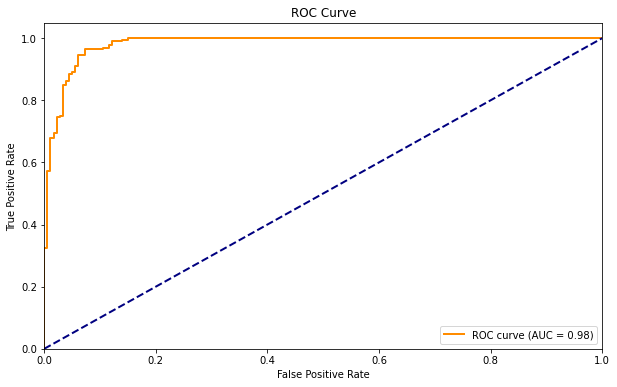

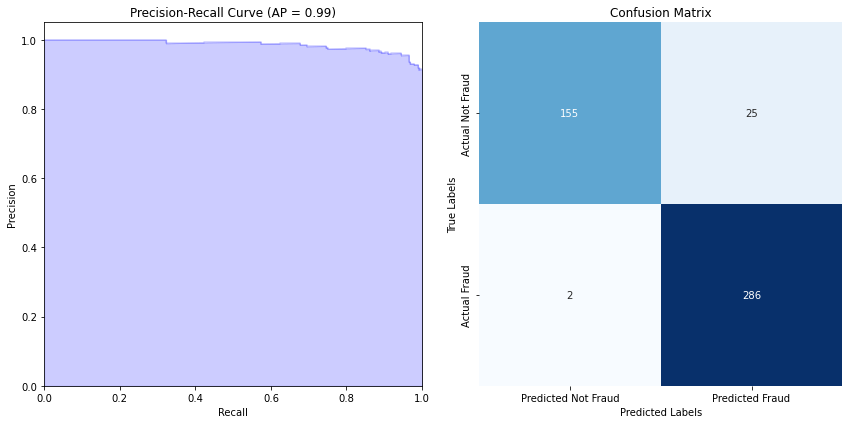

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import seaborn as sns

y_probabilities = best_estimator.predict_proba(X_test)
probability_class_1 = y_probabilities[:, 1]

# ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, probability_class_1)
roc_auc = auc(fpr, tpr)

# Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, probability_class_1)
average_precision = average_precision_score(y_test, probability_class_1)

# Predict binary
y_pred_binary = best_estimator.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Create a single plot for ROC curve (size: 10x10)
plt.figure(figsize=(10, 6))

# ROC Curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Create column-wise subplots for Precision-Recall Curve and Confusion Matrix (size: 12x4)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Precision-Recall Curve
axes[0].step(recall, precision, color='b', alpha=0.2, where='post')
axes[0].fill_between(recall, precision, step='post', alpha=0.2, color='b')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlim([0.0, 1.0])
axes[0].set_title('Precision-Recall Curve (AP = %0.2f)' % average_precision)

# Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=['Predicted Not Fraud', 'Predicted Fraud'], yticklabels=['Actual Not Fraud', 'Actual Fraud'], ax=axes[1])
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')
axes[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

The closer the ROC curve is to top left corner, the higher the recall. Right now, we have achieved the maximum recall.

Inorder to obtain the best F1 performance, the model needs to maximize the distance from the roc curve distance from the diagonal. We can directly get this cut-off using Youden's J technique as below (or else just use F1 as the scoring metric and train the model again)

# Optimizing recall-precision for fraud detection using Youden's J

In [29]:
sensitivity = tpr
specificity = 1 - fpr

J = sensitivity + specificity - 1

optimal_idx = np.argmax(J)
optimal_threshold = thresholds_roc[optimal_idx]

print(f'Optimal Threshold based on Youden\'s J statistic: {optimal_threshold}')
y_pred_optimal = [1 if p > optimal_threshold else 0 for p in probability_class_1]

Optimal Threshold based on Youden's J statistic: 0.687914687039013


### Final binary result

Below is the difference in results after and before Hypertuning the cut-off values for prediction for best F1 score

### F1 score before Youden's J

              precision    recall  f1-score   support

           0       0.99      0.86      0.92       180
           1       0.92      0.99      0.95       288

    accuracy                           0.94       468
   macro avg       0.95      0.93      0.94       468
weighted avg       0.95      0.94      0.94       468



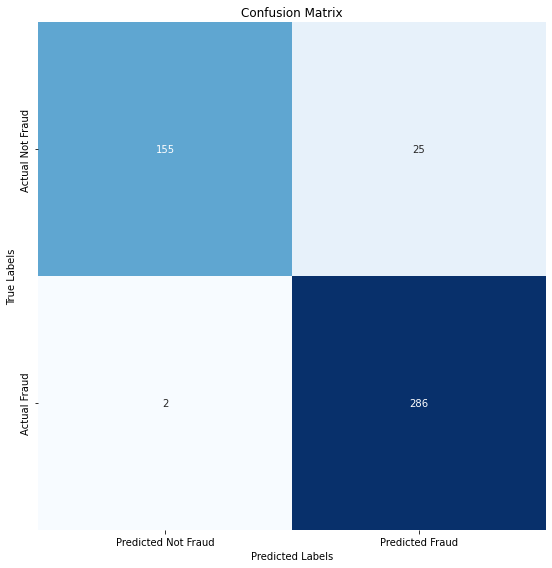

In [30]:
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=['Predicted Not Fraud', 'Predicted Fraud'], yticklabels=['Actual Not Fraud', 'Actual Fraud'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

### F1 score after Youden's J

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       180
           1       0.96      0.96      0.96       288

    accuracy                           0.95       468
   macro avg       0.95      0.94      0.95       468
weighted avg       0.95      0.95      0.95       468



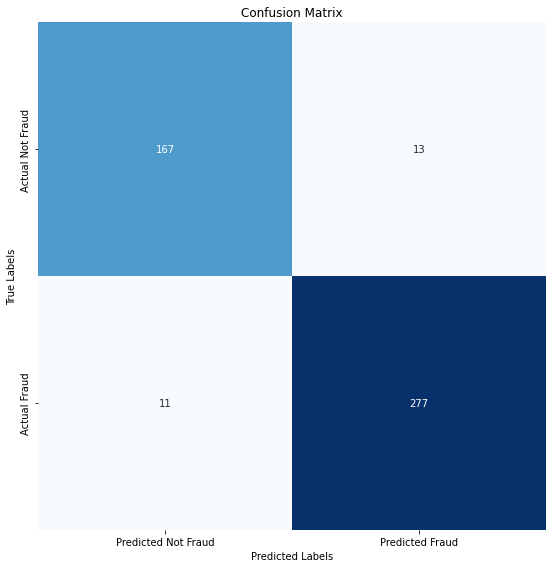

In [32]:
print(classification_report(y_test, y_pred_optimal))

conf_matrix = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=['Predicted Not Fraud', 'Predicted Fraud'], yticklabels=['Actual Not Fraud', 'Actual Fraud'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

# Model - Multi

For the training of this model, we only need to train with those instances where 'isfraud' == 1



In [33]:
import pandas as pd

df = pd.read_csv("banktransaction.csv")

df = pd.get_dummies(df, columns=['typeofaction'])

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour

df = df[df['isfraud'] == 1]


y_isfraud = df['isfraud']
y = df['typeoffraud']

df = df.drop(columns=['date','typeoffraud','isfraud'])
X = df.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
X_train.head()

,sourceid,destinationid,amountofmoney,typeofaction_cash-in,typeofaction_transfer,year,month,day,hour
1121,59658,31163,363046,0,1,2019,3,2,15
48,92735,78865,306536,1,0,2019,7,5,11
155,31439,20213,554346,1,0,2019,5,24,13
306,82410,59581,713808,1,0,2019,5,25,11
1286,40037,73055,361845,0,1,2019,3,7,11


In [35]:
y_train.head(8)

1121    type3
48      type1
155     type1
306     type1
1286    type3
462     type2
1098    type3
712     type2
Name: typeoffraud, dtype: object

The scikitlearn random forest will automatically encode target variables.

In [36]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='recall')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print(f"Best Parameters: {best_params}")

y_pred = best_estimator.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 1.0
              precision    recall  f1-score   support

       type1       1.00      1.00      1.00        80
       type2       1.00      1.00      1.00       103
       type3       1.00      1.00      1.00        97

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280



In [38]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df = pd.read_csv("banktransaction.csv")
df = pd.get_dummies(df, columns=['typeofaction'])

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour

df = df[df['isfraud'] == 1]

y_isfraud = df['isfraud']
y = df['typeoffraud']

df = df.drop(columns=['date','typeoffraud','isfraud'])
X = df.copy()

y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test, y_train

(array([1, 1, 0, 1, 0, 1, 0, 1, 2, 1, 2, 2, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 2, 0, 2, 1, 1,
        0, 2, 2, 1, 0, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 1, 0, 0, 1, 2, 1, 2,
        2, 0, 0, 2, 2, 1, 1, 1, 0, 0, 2, 0, 2, 2, 0, 2, 1, 1, 1, 2, 2, 0,
        2, 1, 0, 1, 2, 1, 2, 1, 2, 2, 0, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1,
        1, 2, 2, 0, 2, 2, 1, 0, 0, 0, 2, 2, 1, 1, 0, 0, 0, 0, 0, 2, 1, 1,
        0, 1, 2, 0, 2, 1, 1, 1, 2, 0, 2, 1, 2, 2, 0, 2, 1, 1, 2, 2, 2, 1,
        1, 2, 2, 2, 1, 2, 1, 1, 2, 0, 2, 0, 0, 1, 1, 1, 0, 0, 2, 1, 1, 1,
        0, 2, 2, 1, 2, 1, 1, 1, 0, 2, 2, 1, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2,
        1, 2, 2, 2, 1, 0, 0, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 0, 2,
        2, 1, 1, 1, 1, 2, 0, 0, 2, 0, 1, 1, 1, 2, 1, 2, 1, 1, 0, 2, 0, 2,
        0, 1, 0, 0, 2, 2, 1, 2, 0, 1, 0, 2, 1, 1, 1, 0, 0, 1, 2, 0, 1, 1,
        2, 2, 2, 2, 0, 0, 2, 2, 1, 1, 1, 0, 2, 0, 0, 0]),
 array([2, 0, 0, ..., 2, 1, 2]))

# Understanding why multi-class model is performing so well

First lets start by understanding what features are allowing the model to provide a perfect typeoffraud detection



                 Feature  Importance
2          amountofmoney    0.495412
3   typeofaction_cash-in    0.243658
4  typeofaction_transfer    0.223337
1          destinationid    0.022055
0               sourceid    0.009967
7                    day    0.002764
8                   hour    0.001826
6                  month    0.000980
5                   year    0.000000


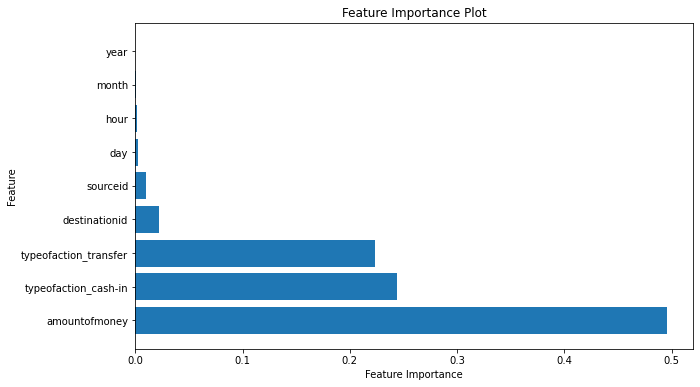

In [39]:
feature_importance_values = best_estimator.feature_importances_

# Create a DataFrame to associate feature names with their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance_values})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

From the above graph, it seems amountofmoney and typeofaction are the most important features. Lets dig deeper



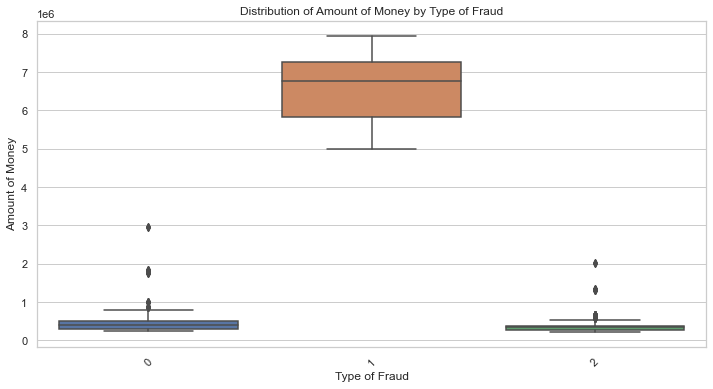

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.boxplot(x=y, y=X['amountofmoney'], data=df)
plt.title('Distribution of Amount of Money by Type of Fraud')
plt.xlabel('Type of Fraud')
plt.ylabel('Amount of Money')
plt.xticks(rotation=45)  
plt.show()

It seems that type1 fraud occurs only after a certain amount of money



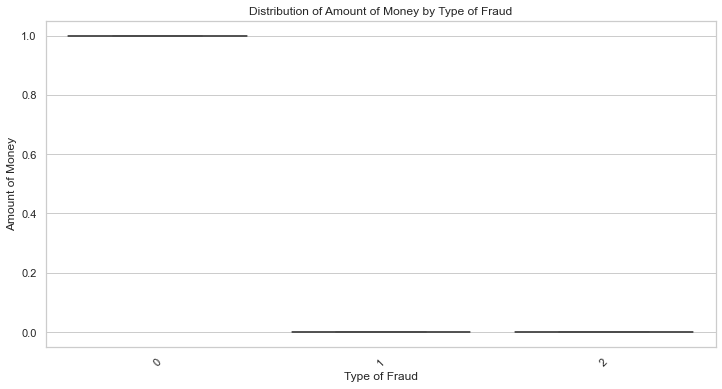

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.boxplot(x=y, y=X['typeofaction_cash-in'], data=df)
plt.title('Distribution of Amount of Money by Type of Fraud')
plt.xlabel('Type of Fraud')
plt.ylabel('Amount of Money')
plt.xticks(rotation=45)  
plt.show()

The type0 fraud occurs only when typeoftransaction is cashin



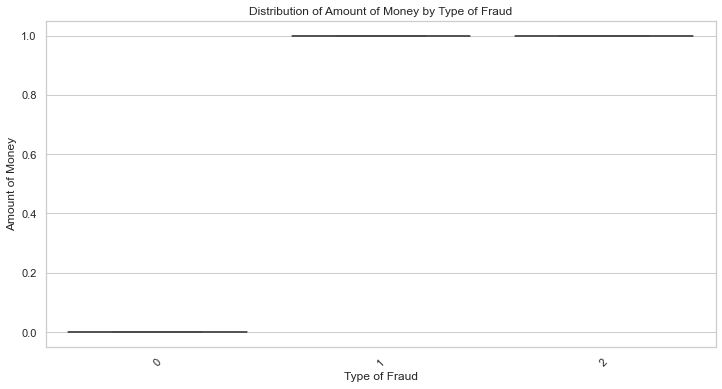

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.boxplot(x=y, y=X['typeofaction_transfer'], data=df)
plt.title('Distribution of Amount of Money by Type of Fraud')
plt.xlabel('Type of Fraud')
plt.ylabel('Amount of Money')
plt.xticks(rotation=45)  
plt.show()

The type 2 fraud only occurs in transfers



### Explaination for 100% metrics on multi-class model

- Type1 fraud occurs only after a certain amount of money, where type0 and type2 frauds never occur
- Type0 fraud occurs only on cash-in transcations
- Type2 fraud occurs only on online-transfers

Instead of a ML model, we can just hardcode the solution for this as below

# Testing data

The below can be used to test whether web app works as expected



In [45]:
df = pd.read_csv("banktransaction.csv")

unique_values = df['typeoffraud'].unique()
new_df = pd.DataFrame()
for value in unique_values:
    row = df[df['typeoffraud'] == value].iloc[0]
    new_df = new_df.append(row, ignore_index=True)
new_df.head()

,typeofaction,sourceid,destinationid,amountofmoney,date,isfraud,typeoffraud
0,cash-in,30105.0,28942.0,494528.0,2019-07-19 14:40:00,1.0,type1
1,transfer,42454.0,32893.0,7270189.0,2019-02-25 11:50:00,1.0,type2
2,transfer,3508.0,28046.0,328814.0,2019-05-01 10:40:00,1.0,type3
3,cash-in,8764.0,60280.0,2124536.0,2019-04-20 09:35:00,0.0,none
